## Import Libraries

In [13]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F 
from pickletools import optimize
from numpy import average
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader 
from torchvision import transforms, datasets 
# from model import Flowers_Classifier
import torch.optim as optim 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 

## Build Model

In [14]:
class Flowers_Classifier(nn.Module):
    def __init__(self):
        super(Flowers_Classifier, self).__init__()   

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=32,  kernel_size=5,  stride=1,  padding=0)  
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,  kernel_size=5,  stride=2,  padding=0)  
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=32,  kernel_size=5,  stride=1,  padding=0)                                          

        self.pool1 = nn.MaxPool2d(kernel_size=5, stride=1)

        self.fc1 = nn.Linear(32*46*46, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 102)

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool1( F.relu( self.conv1(x) ))
        x = self.pool1( F.relu( self.conv2(x) ))
        x = self.pool1( F.relu( self.conv3(x) ))

        # print(x.shape)

        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)

        x = self.softmax(x)

        return x

## Check Model

In [15]:
fake_data = torch.rand((32, 1, 128, 128))
model = Flowers_Classifier()

print(model.forward(fake_data))

tensor([[0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101],
        [0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101],
        [0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101],
        ...,
        [0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101],
        [0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101],
        [0.0095, 0.0097, 0.0101,  ..., 0.0092, 0.0100, 0.0101]],
       grad_fn=<SoftmaxBackward0>)


## Transformations

In [16]:
transforms_train = transforms.Compose([transforms.Grayscale(), transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5,])])
transforms_test  = transforms.Compose([transforms.Grayscale(), transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5,])])

In [17]:
root_path = "C:/Users/zorve/OneDrive/Documents/github datasets/oxford_flowers/"

datasets_train = datasets.ImageFolder(root= root_path + 'train', transform=transforms_train)
datasets_test  = datasets.ImageFolder(root= root_path + 'test',  transform=transforms_test)

dataloader_train = DataLoader(dataset=datasets_train, batch_size=32, shuffle=True)
dataloader_test  = DataLoader(dataset=datasets_test,  batch_size=32, shuffle=True)

## Model, Loss Function, Activation Function

In [18]:
model = Flowers_Classifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = 'cuda' if torch.cuda.is_available() else 'cpu' 
print(device)

cpu


## Train Model

In [19]:

epochs, all_train_losses, all_test_losses, all_accuracies = 5, [], [], []

for epoch in range(epochs):
    train_losses, test_losses, test_accuracies = 0, 0, 0 
    for idx_train, (feature_train, target_train) in enumerate(iter(dataloader_train)):

        optimizer.zero_grad()

        prediction_train = model.forward(feature_train)
        loss_train = criterion(prediction_train, target_train)
        loss_train.backward()
        optimizer.step()

        train_losses += loss_train.item()

    average_train_losses = train_losses/len(dataloader_train)
    all_train_losses.append(average_train_losses)

    torch.save({"model_state": model.state_dict(), "input_size": 28*28}, 'saved_training_model')

    model.eval()
    with torch.no_grad():
        for idx_test, (feature_test, target_test) in enumerate(iter(dataloader_test)): 

            prediction_test = model.forward(feature_test)
            loss_test = criterion(prediction_test, target_test)

            test_losses += loss_test.item() 

            prediction_class = torch.argmax(prediction_test, dim=1)
            test_accuracies += accuracy_score(prediction_class, target_test)

        average_test_losses = test_losses/len(dataloader_test)
        all_test_losses.append(average_test_losses)

        average_test_accuracies = test_accuracies/len(dataloader_test)
        all_accuracies.append(average_test_accuracies)

    torch.save({"model_state": model.state_dict(), "input_size": 28*28}, 'saved_testing_model')

    model.train()

    print(f'{epoch+1:3}/{epochs} :  Train Loss : {average_train_losses:.6f}  |  Test Loss : {average_test_losses:.6f}  | Accuracy : {average_test_accuracies:.6f}')

  1/5 :  Train Loss : 4.627694  |  Test Loss : 4.627255  | Accuracy : 0.014423
  2/5 :  Train Loss : 4.627197  |  Test Loss : 4.625386  | Accuracy : 0.016293
  3/5 :  Train Loss : 4.627197  |  Test Loss : 4.627255  | Accuracy : 0.014423
  4/5 :  Train Loss : 4.627197  |  Test Loss : 4.627255  | Accuracy : 0.014423
  5/5 :  Train Loss : 4.627146  |  Test Loss : 4.627255  | Accuracy : 0.014423


## Save Model

In [20]:
torch.save({"model_state": model.state_dict(), "input_size": 28*28}, 'saved_final_model')

## Plot Training Results

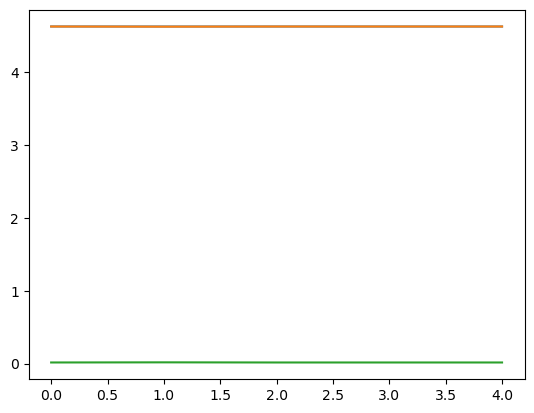

In [21]:
plt.plot(all_train_losses, label='Training Losses')
plt.plot(all_test_losses,  label='Testing Lossess')
plt.plot(all_accuracies,   label='Accuracy')
plt.show()

## Load Trained Model

In [26]:
train_modeled = torch.load('saved_final_model')

# train_modeled = torch.load('checkpoint_training')
# train_modeled.to('cpu')

model_state = train_modeled['model_state']

model = Flowers_Classifier()
model.load_state_dict(model_state)

<All keys matched successfully>

## Make Prediction

In [27]:
from PIL import ImageTk, Image

def make_predict(image_path, model, number2classes):
    preprocessor = transforms.Compose([transforms.Grayscale(), transforms.Resize((128, 128)), transforms.ToTensor(), transforms.Normalize(mean=[0.5,], std=[0.5,])])
    
    image = Image.open(image_path)
    processed_image = preprocessor(image)
    processed_image = processed_image.view(1, *processed_image.shape)

    model.eval()
    with torch.no_grad():
        prediction = model.forward(processed_image)
        _, prediction_class = torch.max(prediction, dim=1)

    plt.imshow(image, cmap='gray')
    plt.title(f'Prediction Flower:  {(number2classes[prediction_class.item()]).upper()}     ID:  {prediction_class.item()}' , fontsize=18)
    plt.show()

    return

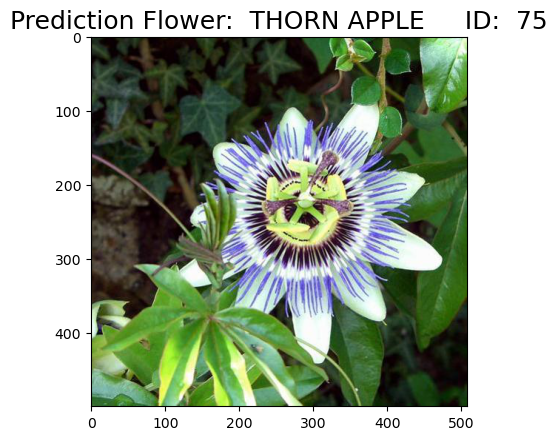

In [28]:
from four_datasets import number2classes

image_path = "C:/Users/zorve/OneDrive/Documents/github datasets/oxford_flowers/validate/image_00005.jpg"

make_predict(image_path, model, number2classes) 


## USE CLI for Prediction

In [ ]:

import argparse 
parser = argparse.ArgumentParser(description='Image path')
parser.add_argument('first', type=str, help='Input the path of the image')
args = parser.parse_args()
link1 = args.first 
image_path_arg = "C:/Users/zorve/OneDrive/Documents/github datasets/oxford_flowers/validate/" +  link1 